In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vmdpy import VMD
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D,Input, UpSampling2D
from keras import Model
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [104]:
# VMD分解
# init = 1  #均匀分布初始化       
def VMD_plot(plot,K=3, signal_name='norm', tau=0,alpha=2000, DC=0, init=1, tol=1e-7):
    signal = data[signal_name]
    (imf,imf_hat,omega)=VMD(signal, alpha, tau, K, DC, init, tol)
    if plot==1:
        # 展示原信号和各IMF
        fig,axes = plt.subplots(nrows=K+1, ncols=1, figsize=(10,8))
        axes[0].plot(signal)
        axes[0].set_ylabel(signal_name)
        for i in range(K):
            axes[i+1].plot(imf[i])
        plt.tight_layout()
    if plot==2:
        # 展示中心频率的迭代情况
        for i in range(len(omega[0])):
            plt.plot(omega[:,i],np.arange(len(omega)))
            plt.scatter(omega[-1,i],len(omega))
            plt.gca().invert_yaxis()
        print(omega[-1])
    return imf,imf_hat,omega


# 一些测试函数
# def data1d_window(imf_i, window = 100,stride = 15):
#     '''
#     imf是单变量的时序数据
    
#     '''
#     data_ = []
#     datao_=[]
#     cnt = -1
#     while True:
#         cnt+=1
#         if stride*cnt+window > len(imf_i)-1:
#             break
#         data_.append(imf_i[stride*cnt:stride*cnt+window])
#     return np.array(data_)


# def dataKd_window(imf, window = 100,stride = 15):
#     data_=[]
#     cnt = -1
#     while True:
#         cnt+=1
#         if stride*cnt+window > len(imf[0])-1:
#             break
#         data_.append(imf[:,stride*cnt:stride*cnt+window])
#     return np.array(data_)
        
        

载入数据

In [105]:
columns = ['norm','T2','T3','T4','T5']
data = pd.DataFrame(columns = columns)
for i in [1,2,3,4,5]:
    path = 'E:\\2022_8_AbsignalRecog_VDM\\data\\T'+str(i)+'.csv'
    data[columns[i-1]] = pd.read_csv(path)

# 最后一位重复一次，凑2048个数据，比较规整，也有利于网络里池化等操作。    
data.loc[2047] = data.loc[2046]
data

,norm,T2,T3,T4,T5
0,-0.0000,-0.0000,-0.0000,-0.0000,-0.0
1,-0.0000,-0.0000,-0.0000,-0.0000,-0.0
2,-0.0000,1.6854,-0.0000,-0.0000,-0.0
3,-0.0000,-6.7416,-0.0000,-0.0000,-0.0
4,-1.9048,2.2472,-0.0000,-0.0000,-0.0
...,...,...,...,...,...
2043,-4.7619,1.1236,2.6087,1.6484,-0.0
2044,-4.7619,0.5618,2.6087,1.6484,-0.0
2045,-4.7619,0.5618,2.6087,1.6484,-0.0
2046,-4.7619,0.5618,2.6087,1.6484,-0.0


下面的函数将每一个数据构造成01二值图像

目的是生成的特征图每个小方块的数值，可以理解成原图对应区域内数值为1的概率大小
这样后续直接对特征图之间计算KL散度，比较符合KL散度的定义，可解释性强一些。。


In [107]:
# 归一化
# 数据构建输入
def construct_data(imf,k,plot,dataset=100,sample=0):
    '''
    归一化，增加噪声，并将数据构建成01图像输入
    
    '''
    imf = ((2*(MinMaxScaler().fit_transform(imf.swapaxes(0,1)).swapaxes(0,1))-1)*255).astype(int) #映射到-255到255
    size = imf[k].shape
    imfk = imf[k].tolist()
    imgk = imfk.copy()
#     print(np.max(imfk),np.min(imfk),'是否是+-255')
    train_Data = []
    for i in range(dataset):
        for cnt,x in enumerate(imgk):
            if cnt!=0:
                x += np.random.randint(low=-20,high=20) #最大幅值百分之8的噪声。
                if x > 255:
                    x=255
                if x < -255:
                    x=-255
                
            imgk[cnt] = [0]*512
            if x <= 0:
                imgk[cnt][x+255:256] = (1,)*(1-x)
            if x >= 0:
                imgk[cnt][256:x+257] = (1,)*(1+x)
                
#         print(np.array(imgk).shape)
        imgk= np.array(imgk).swapaxes(0,1) # (nrows,ncols )
        train_Data.append(imgk)
        imgk = imfk.copy()
        

    train_Data = np.array(train_Data).reshape(100, 512, 2048, 1)
    # np.abs(np.random.normal(loc=0,scale=1e-2,size=(3,4))) #增加噪声
    print('train_Data.shape:',train_Data.shape) #(batch_size,nrows,ncols)
    if plot==1:
        fig = plt.figure(figsize=(8,3))
        plt.imshow(train_Data[sample,:,:,0])
    return train_Data

In [ ]:
imf1,imf_hat1,omega1 = VMD_plot(3,signal_name='norm')
imf1 = imf1.tolist()
imf1.append(data['norm'])
imf1 = np.array(imf1,dtype=object)
imf1.shape

train_Data.shape: (100, 512, 2048, 1)


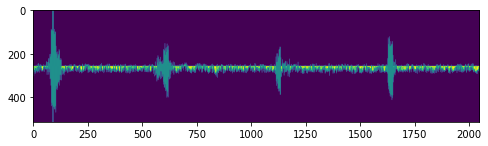

In [108]:
train_Data = construct_data(imf1,3,1,sample=1)  #画出某个添加了噪声的样本

In [109]:
x_train, x_test, y_train, y_test = train_test_split(train_Data , train_Data,\
                                                    random_state = 36, test_size = 0.2, shuffle = False)
x_train.shape

(80, 512, 2048, 1)

In [110]:
# 模型构建

hidden_layer = 16
encode_dim = 8

CHANNEL_1 = 6
CHANNEL_2 = 3
CHANNEL_3 = 1
CHANNEL_OUTPUT = train_Data.shape[3]

data_format = 'channels_last' #'channels_first'


input_image = Input(shape=(train_Data.shape[1],train_Data.shape[2],train_Data.shape[3]),name='input') # data_format
x = Conv2D(CHANNEL_1, (3, 3), activation='relu', padding="same", data_format=data_format,name='conv1')(input_image)
x = MaxPool2D((4, 4), padding='same', data_format=data_format,name='ups1')(x)
x = Conv2D(CHANNEL_2, (3, 3), activation='relu', padding="same", data_format=data_format,name='conv2')(x)
x = MaxPool2D((4, 4), padding='same', data_format=data_format,name='ups2')(x)
x = Conv2D(CHANNEL_3, (3, 3), activation='relu', padding="same", data_format=data_format,name='conv3')(x)
encoded = MaxPool2D((8, 4), padding='same', data_format=data_format,name='op_encode')(x)

x = Conv2D(CHANNEL_3, (3, 3), activation='relu', padding='same',data_format=data_format,name='conv4')(encoded)
x = UpSampling2D((8, 4), data_format=data_format,name='ups3')(x)
x = Conv2D(CHANNEL_2, (3, 3), activation='relu', padding='same',data_format=data_format,name='conv5')(x)
x = UpSampling2D((4, 4), data_format=data_format,name='ups4')(x)
x = Conv2D(CHANNEL_1, (3, 3), activation='relu', padding='same',data_format=data_format,name='conv6')(x)
x = UpSampling2D((4, 4), data_format=data_format,name='ups5')(x)
decoded = Conv2D(CHANNEL_OUTPUT, (3, 3), activation='sigmoid', padding='same', data_format=data_format,name='op_decode')(x)

# build autoencoder, encoder, decoder
autoencoder0 = Model(inputs=input_image, outputs=decoded)
encoder0 = Model(inputs=input_image, outputs=autoencoder0.get_layer('op_encode').output)

autoencoder1 = Model(inputs=input_image, outputs=decoded)
encoder1 = Model(inputs=input_image, outputs=autoencoder1.get_layer('op_encode').output)

autoencoder2 = Model(inputs=input_image, outputs=decoded)
encoder2 = Model(inputs=input_image, outputs=autoencoder2.get_layer('op_encode').output)

autoencoder3 = Model(inputs=input_image, outputs=decoded)
encoder3 = Model(inputs=input_image, outputs=autoencoder3.get_layer('op_encode').output)


# 对 K+1 四个维度(分别是IMF1,IMF2,IMF3,原始信号)的图像分别训练编码器
autoencoder0.compile(optimizer='adam', loss='mse') #'binary_crossentropy'
autoencoder1.compile(optimizer='adam', loss='mse')
autoencoder2.compile(optimizer='adam', loss='mse')
autoencoder3.compile(optimizer='adam', loss='mse')

autoencoder0.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 2048, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 512, 2048, 6)      60        
_________________________________________________________________
ups1 (MaxPooling2D)          (None, 128, 512, 6)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 512, 3)       165       
_________________________________________________________________
ups2 (MaxPooling2D)          (None, 32, 128, 3)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 128, 1)        28        
_________________________________________________________________
op_encode (MaxPooling2D)     (None, 4, 32, 1)          0   

In [112]:
def batch_construct(name='norm'):  
    imf,imf_hat,omega= VMD_plot(3,signal_name=name)
    imf = imf.tolist()
    imf.append(data[name])
    imf = np.array(imf,dtype=object)
    print(imf)
    print('imf_shape',imf.shape)
    train_Data=[]
    for i in range(4):
        train_Data.append(construct_data(imf,i,0))
    train_Data = np.array(train_Data)
    print('train_Data.shape:',train_Data.shape)
    return train_Data

train_Data1 = batch_construct(name='norm') #每个维度分别是： K+1，样本数目，图像高，图像长，图像通道数
train_Data1.shape

[[-2.1404513428916117 -2.188227007579603 -2.2778125324084257 ...
  -4.673162717148296 -4.676855758807861 -4.678917953335012]
 [-0.2881643548091263 0.08417278085309915 0.4290421904326071 ...
  -0.044386179108120594 -0.00919839724314548 0.032732859053469066]
 [-0.2974312585885195 0.3322897013816533 -0.3483984911142345 ...
  0.29786110255844905 -0.295532023271603 0.2925727039917262]
 [-0.0 -0.0 -0.0 ... -4.7619 -4.7619 -4.7619]]
imf_shape (4, 2048)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)


(4, 100, 512, 2048, 1)

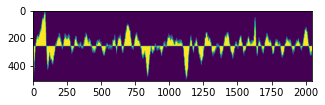

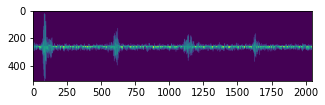

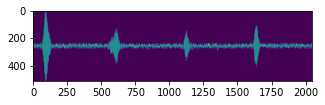

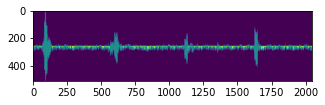

In [113]:
# 展示二值图像
plt.figure(figsize=(5,5))
plt.imshow(train_Data1[0][0,:,:,0]) #IMF1 
plt.figure(figsize=(5,5))
plt.imshow(train_Data1[1][0,:,:,0]) #IMF2
plt.figure(figsize=(5,5))
plt.imshow(train_Data1[2][0,:,:,0]) #IMF3
plt.figure(figsize=(5,5))
plt.imshow(train_Data1[3][0,:,:,0]) #Original Signal

用T1，共100个样本，在IMF1,IMF2,IMF3和原始信号四个维度训练四个自编码器

这四个维度如果训练一个编码器效果一致不太好，迭代也比较慢

In [116]:
Epoch = 6 
Batch_size = 16

datain = train_Data1[0].reshape(train_Data1.shape[1],train_Data1.shape[2],train_Data1.shape[3],1)
x_train, x_test, y_train, y_test = train_test_split(datain ,datain,\
                                                    random_state = 36, test_size = 0.2, shuffle = False)
print('x_trainshape:',x_train.shape)
autoencoder0.fit(x_train,y_train,
                epochs=Epoch,
                batch_size=Batch_size,
                validation_data=(x_test, y_test))


datain = train_Data1[1].reshape(train_Data1.shape[1],train_Data1.shape[2],train_Data1.shape[3],1)
x_train, x_test, y_train, y_test = train_test_split(datain ,datain,\
                                                    random_state = 36, test_size = 0.2, shuffle = False)
autoencoder1.fit(x_train,y_train,
                epochs=Epoch,
                batch_size=Batch_size,
                validation_data=(x_test, y_test))


datain = train_Data1[2].reshape(train_Data1.shape[1],train_Data1.shape[2],train_Data1.shape[3],1)
x_train, x_test, y_train, y_test = train_test_split(datain ,datain,\
                                                    random_state = 36, test_size = 0.2, shuffle = False)
autoencoder2.fit(x_train,y_train,
                epochs=Epoch,
                batch_size=Batch_size,
                validation_data=(x_test, y_test))


datain = train_Data1[3].reshape(train_Data1.shape[1],train_Data1.shape[2],train_Data1.shape[3],1)
x_train, x_test, y_train, y_test = train_test_split(datain ,datain,\
                                                    random_state = 36, test_size = 0.2, shuffle = False)
autoencoder3.fit(x_train,y_train,
                epochs=Epoch,
                batch_size=Batch_size,
                validation_data=(x_test, y_test))

x_trainshape: (80, 512, 2048, 1)
Train on 80 samples, validate on 20 samples
Epoch 1/2
80/80 [==============================] - 36s 447ms/step - loss: 0.1060 - val_loss: 0.1025
Epoch 2/2
80/80 [==============================] - 38s 469ms/step - loss: 0.0991 - val_loss: 0.0954
Train on 80 samples, validate on 20 samples
Epoch 1/2
80/80 [==============================] - 38s 469ms/step - loss: 0.0510 - val_loss: 0.0462
Epoch 2/2
80/80 [==============================] - 37s 467ms/step - loss: 0.0438 - val_loss: 0.0406
Train on 80 samples, validate on 20 samples
Epoch 1/2
80/80 [==============================] - 38s 475ms/step - loss: 0.0412 - val_loss: 0.0402
Epoch 2/2
80/80 [==============================] - 37s 469ms/step - loss: 0.0399 - val_loss: 0.0394
Train on 80 samples, validate on 20 samples
Epoch 1/2
80/80 [==============================] - 38s 477ms/step - loss: 0.0406 - val_loss: 0.0402
Epoch 2/2
80/80 [==============================] - 39s 482ms/step - loss: 0.0400 - val_loss

观察一下autoencoder 在故障组的正确率，以T2为例

In [118]:
train_Data2 = batch_construct(name='T2')
his=[]
ae = [autoencoder0,autoencoder1,autoencoder2,autoencoder3]
for i in range(4):
    his_ = []
    testcode = ae[i].predict(train_Data2[i].reshape(train_Data2.shape[1],train_Data2.shape[2],train_Data2.shape[3],1))
    print(testcode.shape)
    for bs in range(len(train_Data2[0])): #sample_num,x,x,1
        his_.append(np.mean((testcode[bs]-train_Data2[1][bs])**2))
    his.append(np.mean(his_))
print('loss分别为:',his)

[[-0.358285532471214 -0.3505229815218607 -0.34001708531084596 ...
  0.5417167138883865 0.5367437860886213 0.5382331568365444]
 [-0.2988930213209048 0.4197194713441982 0.24950331674681286 ...
  0.15755367666956507 0.03844862063633858 -0.10083280901707123]
 [0.8938355949347379 -1.3507116926769547 1.809613639212217 ...
  -1.5053979497315904 1.1598941163340828 -0.8261716224896835]
 [-0.0 -0.0 1.6854 ... 0.5618 0.5618 0.5618]]
imf_shape (4, 2048)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)
(100, 512, 2048, 1)
(100, 512, 2048, 1)
(100, 512, 2048, 1)
(100, 512, 2048, 1)
loss分别为: [0.03679159619547004, 0.03384933554693528, 0.035283462424668614, 0.03490889011352695]


效果还可以

继续观察一些 编码后的图像

[[-2.1404513428916117 -2.188227007579603 -2.2778125324084257 ...
  -4.673162717148296 -4.676855758807861 -4.678917953335012]
 [-0.2881643548091263 0.08417278085309915 0.4290421904326071 ...
  -0.044386179108120594 -0.00919839724314548 0.032732859053469066]
 [-0.2974312585885195 0.3322897013816533 -0.3483984911142345 ...
  0.29786110255844905 -0.295532023271603 0.2925727039917262]
 [-0.0 -0.0 -0.0 ... -4.7619 -4.7619 -4.7619]]
imf_shape (4, 2048)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)


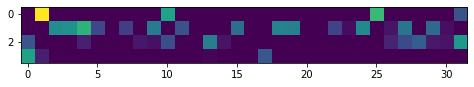

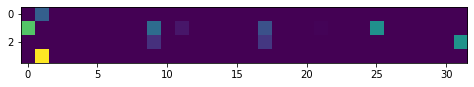

In [125]:
train_Data1 = batch_construct(name='norm')
img10_code = encoder0.predict(train_Data1[0].reshape(train_Data1.shape[1],train_Data1.shape[2],train_Data1.shape[3],1))
fig = plt.figure(figsize=(8,3))
plt.imshow(img10_code[0,:,:,0])

img11_code = encoder0.predict(train_Data1[1].reshape(train_Data1.shape[1],train_Data1.shape[2],train_Data1.shape[3],1))
fig = plt.figure(figsize=(8,3))
plt.imshow(img11_code[0,:,:,0])

[[-0.358285532471214 -0.3505229815218607 -0.34001708531084596 ...
  0.5417167138883865 0.5367437860886213 0.5382331568365444]
 [-0.2988930213209048 0.4197194713441982 0.24950331674681286 ...
  0.15755367666956507 0.03844862063633858 -0.10083280901707123]
 [0.8938355949347379 -1.3507116926769547 1.809613639212217 ...
  -1.5053979497315904 1.1598941163340828 -0.8261716224896835]
 [-0.0 -0.0 1.6854 ... 0.5618 0.5618 0.5618]]
imf_shape (4, 2048)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)


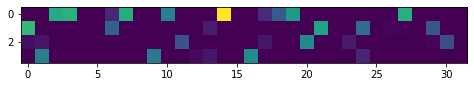

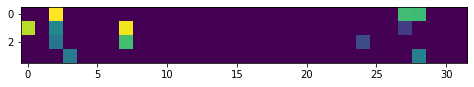

In [126]:
train_Data2 = batch_construct(name='T2')
img20_code = encoder0.predict(train_Data2[0].reshape(train_Data2.shape[1],train_Data2.shape[2],train_Data2.shape[3],1))
fig = plt.figure(figsize=(8,3))
plt.imshow(img20_code[0,:,:,0])

img21_code = encoder0.predict(train_Data2[1].reshape(train_Data2.shape[1],train_Data2.shape[2],train_Data2.shape[3],1))
fig = plt.figure(figsize=(8,3))
plt.imshow(img21_code[0,:,:,0])

In [128]:
def imgcode_construct(name='norm'): 
    '''
    提取原始数据，VMD分解后输出K+1维度的neck编码
    '''
    imf,imf_hat,omega= VMD_plot(plot=5,signal_name=name)
    imf = imf.tolist()
    imf.append(data[name])
    imf = np.array(imf,dtype=object)
    imf.shape
    train_Data=[]
    for k in range(4):
        train_Data.append(construct_data(imf,k,0))
    train_Data = np.array(train_Data)
    print('train_Data.shape:',train_Data.shape)
    img0_code = encoder0.predict(train_Data[0].reshape(100,512,2048,1))
    img1_code = encoder1.predict(train_Data[1].reshape(100,512,2048,1))
    img2_code = encoder2.predict(train_Data[2].reshape(100,512,2048,1))
    img3_code = encoder3.predict(train_Data[3].reshape(100,512,2048,1)) #100,4,32,1
    return img0_code,img1_code,img2_code,img3_code


In [129]:
T1_code = imgcode_construct(name='norm') 
T2_code = imgcode_construct(name='T2')
T3_code = imgcode_construct(name='T3')
T4_code = imgcode_construct(name='T4')
T5_code = imgcode_construct(name='T5')

train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (100, 512, 2048, 1)
train_Data.shape: (4, 100, 512, 2048, 1)


In [130]:
np.array(T1_code).shape

(4, 100, 4, 32, 1)

In [131]:
def hist_scatter(T_code,bins=10):
    '''
    把 bottle neck 的编码转换成频次，可用于计算KL散度
    '''
    T_hist = []
    T_code = np.array(T_code) #4,100,4,32,1
    print('T_codeshape',T_code.shape)
    for code in range(len(T_code)): #100,4,32,1
        hist_count = []
        for sample in range(len(T_code[code])): 
            hist_count_,_ = np.histogram(T_code[code][sample], bins=bins) #4,32,1——>binslen
#             if sample==2:
#                 print('10?:',len(hist_count_))
            hist_count.append(hist_count_) #100,binlen=10
#         print('T_hist:1,100,10——>4,100,10?',T_hist)
        T_hist.append(hist_count) # 4,100,10
    print('T_hist:',np.array(T_hist).shape) # 4,100,10
    T_hist = np.array(T_hist)
    return T_hist
def KL_scatter(hist1,hist2):
    '''
    把两组频次转换成对应的KL散度
    
    '''
    KL = []
    for hz in range(len(hist1)):
        KL_ = []
        for KLhist in zip(hist1[hz],hist2[hz]):   #100,10
            KL_.append([stats.entropy(KLhist[0],KLhist[1]), stats.entropy(KLhist[1],KLhist[0])]) #100,2
        KL.append(KL_) # 4,100,2
    KL = np.array(KL)
    print('KLshape:',KL.shape)
    return KL

def klimf(name='norm'):
    '''
    对各样本计算出特征值 返回格式为sample,feature_num
    '''
    imf,_,_ = VMD_plot(4,signal_name=name)
    imf = (MinMaxScaler().fit_transform(imf.swapaxes(0,1)).swapaxes(0,1))
    _,sigma_,_ = np.linalg.svd(imf)
    imf_ = []
    sigma = []
    imf_.append(imf)
    sigma.append(sigma_)
    for i in range(100-1):
        imf__ = imf + np.random.uniform(size=(3,2048))/5
        imf_.append(imf__)
        _,sigma_,_ = np.linalg.svd(imf__)
        sigma.append(sigma_)
    print('imf_.shape,100,3,2048?',np.array(imf_).shape)
    print('imf__.shape,3,2048?',np.array(imf__).shape)
    print('sigma_.shape,fn?',sigma_)
    print('sigma.shape,100,fn?',np.array(sigma).shape)
    return np.array(sigma)
    

In [132]:
Bins=4
shuffle_index = np.arange(100)+1
shuffle_index[-1]=0
T1_code_ =np.array(T1_code)[:,shuffle_index,:,:,:]
T1HistCode_ = hist_scatter(T1_code_,bins=Bins)

T1HistCode = hist_scatter(T1_code,bins=Bins)
T2HistCode = hist_scatter(T2_code,bins=Bins)

# plt.scatter(KLab(T1_code,img33_code)[:,0],KLab(img13_code,img33_code)[:,1])

T3HistCode = hist_scatter(T3_code,bins=Bins)
T4HistCode = hist_scatter(T4_code,bins=Bins)
T5HistCode = hist_scatter(T5_code,bins=Bins)


T_codeshape (4, 100, 4, 32, 1)
T_hist: (4, 100, 4)
T_codeshape (4, 100, 4, 32, 1)
T_hist: (4, 100, 4)
T_codeshape (4, 100, 4, 32, 1)
T_hist: (4, 100, 4)
T_codeshape (4, 100, 4, 32, 1)
T_hist: (4, 100, 4)
T_codeshape (4, 100, 4, 32, 1)
T_hist: (4, 100, 4)
T_codeshape (4, 100, 4, 32, 1)
T_hist: (4, 100, 4)


In [133]:
KL11 = KL_scatter(np.array(T1_code).swapaxes(0,1).reshape(1,100,-1)+0.001,np.array(T1_code_).swapaxes(0,1).reshape(1,100,-1)+0.001) # +0.01避免分母为0
KL12 = KL_scatter(np.array(T1_code).swapaxes(0,1).reshape(1,100,-1)+0.001,np.array(T2_code).swapaxes(0,1).reshape(1,100,-1)+0.001)
KL13 = KL_scatter(np.array(T1_code).swapaxes(0,1).reshape(1,100,-1)+0.001,np.array(T3_code).swapaxes(0,1).reshape(1,100,-1)+0.001)
KL14 = KL_scatter(np.array(T1_code).swapaxes(0,1).reshape(1,100,-1)+0.001,np.array(T4_code).swapaxes(0,1).reshape(1,100,-1)+0.001)
KL15 = KL_scatter(np.array(T1_code).swapaxes(0,1).reshape(1,100,-1)+0.001,np.array(T5_code).swapaxes(0,1).reshape(1,100,-1)+0.001)

KLshape: (1, 100, 2)
KLshape: (1, 100, 2)
KLshape: (1, 100, 2)
KLshape: (1, 100, 2)
KLshape: (1, 100, 2)


In [145]:
sigmaT1 = klimf(name='norm')
sigmaT2 = klimf(name='T2')
sigmaT3 = klimf(name='T3')
sigmaT4 = klimf(name='T4')
sigmaT5 = klimf(name='T5')

imf_.shape,100,3,2048? (100, 3, 2048)
imf__.shape,3,2048? (3, 2048)
sigma_.shape,fn? [47.39078973  5.77535419  3.74750382]
sigma.shape,100,fn? (100, 3)
imf_.shape,100,3,2048? (100, 3, 2048)
imf__.shape,3,2048? (3, 2048)
sigma_.shape,fn? [47.83929654  8.10945131  4.70362732]
sigma.shape,100,fn? (100, 3)
imf_.shape,100,3,2048? (100, 3, 2048)
imf__.shape,3,2048? (3, 2048)
sigma_.shape,fn? [37.27136451  4.39577804  3.78602524]
sigma.shape,100,fn? (100, 3)
imf_.shape,100,3,2048? (100, 3, 2048)
imf__.shape,3,2048? (3, 2048)
sigma_.shape,fn? [44.70629205  5.16519845  3.82195607]
sigma.shape,100,fn? (100, 3)
imf_.shape,100,3,2048? (100, 3, 2048)
imf__.shape,3,2048? (3, 2048)
sigma_.shape,fn? [48.50357315  4.3681316   3.26360687]
sigma.shape,100,fn? (100, 3)


In [146]:
sigmaT1 = (StandardScaler().fit_transform(sigmaT1.swapaxes(0,1))).swapaxes(0,1).reshape(1,100,3)
sigmaT2 = (StandardScaler().fit_transform(sigmaT2.swapaxes(0,1))).swapaxes(0,1).reshape(1,100,3)
sigmaT3 = (StandardScaler().fit_transform(sigmaT3.swapaxes(0,1))).swapaxes(0,1).reshape(1,100,3)
sigmaT4 = (StandardScaler().fit_transform(sigmaT4.swapaxes(0,1))).swapaxes(0,1).reshape(1,100,3)
sigmaT5 = (StandardScaler().fit_transform(sigmaT5.swapaxes(0,1))).swapaxes(0,1).reshape(1,100,3)
sigmaT1_ = sigmaT1[:,shuffle_index,:]

In [152]:
Kl11 = KL_scatter(np.exp(sigmaT1),np.exp(sigmaT1_)) #取np.exp是因为归一化以后sigmaT1存在非正数
Kl12 = KL_scatter(np.exp(sigmaT1),np.exp(sigmaT2))
Kl13 = KL_scatter(np.exp(sigmaT1),np.exp(sigmaT3))
Kl14 = KL_scatter(np.exp(sigmaT1),np.exp(sigmaT4))
Kl15 = KL_scatter(np.exp(sigmaT1),np.exp(sigmaT5))

KLshape: (1, 100, 2)
KLshape: (1, 100, 2)
KLshape: (1, 100, 2)
KLshape: (1, 100, 2)
KLshape: (1, 100, 2)


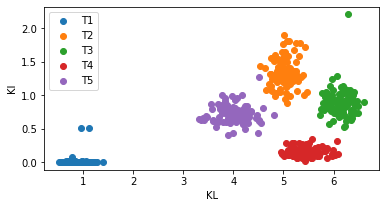

In [160]:
plt.figure(figsize=(6,3))
plt.scatter(KL11[0,:,1],Kl11[0,:,1]*10000,label='T1')
plt.scatter(KL12[0,:,1],Kl12[0,:,1]*10000,label='T2')
plt.scatter(KL13[0,:,1],Kl13[0,:,1]*10000,label='T3')
plt.scatter(KL14[0,:,1],Kl14[0,:,1]*10000,label='T4')
plt.scatter(KL15[0,:,1],Kl15[0,:,1]*10000,label='T5')
plt.xlabel('KL') # KL是基于特征图的散度（分母取T1）
plt.ylabel('Kl') # Kl是基于特征值的散度（分母取T1）
plt.legend()


看起来区分效果比较明显。每类，一百个样本很好的聚集在一起，
其中每一类信号的一百个样本都是通过随机添加8%最大幅度的噪声生成
 